# MNIST classification

## import libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

parameters(**args)

In [2]:
# use cuda if available
use_cuda = True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

train_batch_size = 64*2*2
test_batch_size = 1000

epochs = 14
lr = 1.0
gamma = .7

CUDA Available:  False


In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,))
        ])

## Load Dataset

In [4]:
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=train_batch_size, shuffle=True)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=test_batch_size, shuffle=True)

## Building model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

initialize the model, optimizer and scheduler

In [6]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

build/load the model

In [18]:
try:
    # Load the pretrained model
    model.load_state_dict(torch.load("mnist_cnn.pt", map_location='cpu'))
    test(model, device, test_loader)
except:
    for epoch in range(1, epochs):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()
    torch.save(model.state_dict(), "mnist_cnn.pt")

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


Test set: Average loss: 0.1611, Accuracy: 9895/10000 (99%)



Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# [FGSM Attack](https://arxiv.org/abs/1412.6572)

The ``fgsm_attack`` function takes three
inputs, *image* is the original clean image ($x$), *epsilon* is
the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
is gradient of the loss w.r.t the input image
($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$). The function
then creates perturbed image as

$$
\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}
$$

Finally, in order to maintain the original range of the data, the
perturbed image is clipped to range $[0,1]$.

In [9]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    """
    The ``fgsm_attack`` function takes three
    inputs, *image* is the original clean image ($x$), *epsilon* is
    the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
    is gradient of the loss w.r.t the input image
    ($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$). The function
    then creates perturbed image as

    \begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}

    Finally, in order to maintain the original range of the data, the
    perturbed image is clipped to range $[0,1]$.
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [10]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [11]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

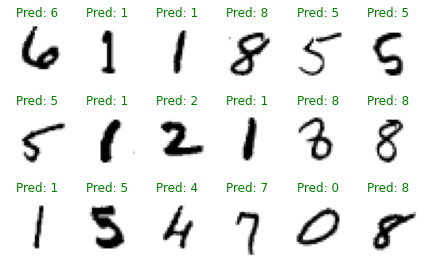

In [12]:
### Illustrate original predictions
yp = model(X)
plot_images(X, y, yp, 3, 6)

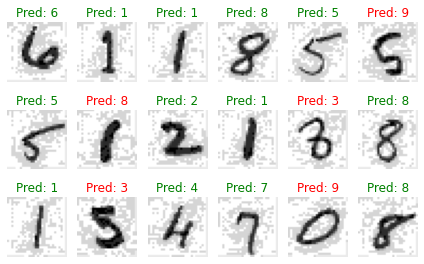

In [13]:
### Illustrate attacked images
delta = fgsm(model, X, y, 0.1)
yp = model(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [31]:
def epoch_adversarial(model, loader, attack, eps):
    total_loss, total_err = 0.,0.

    for X,y in loader:
        X,y = X.to(device), y.to(device)

        delta = attack(model, X, y, eps)
        perturbed_data = X+delta
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
    
err, loss = epoch_adversarial(model, test_loader, fgsm, 0.1)
print("4-layer DNN error: {}, loss: {}".format(err, loss))

4-layer DNN error: 0.3195, loss: 1.3651620149612427


In [32]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
errors = []
accuracies = []
loss = []

for eps in epsilons:
    err, _loss = epoch_adversarial(model, test_loader, fgsm, eps)
    _acc = 1 - err
    errors.append(err)
    accuracies.append(_acc)
    loss.append(_loss)

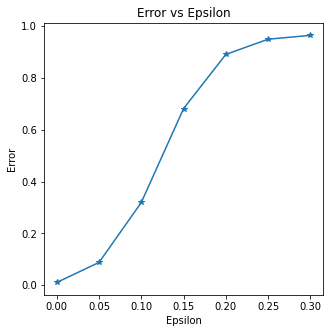

In [33]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, errors, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Error vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Error")
plt.show()

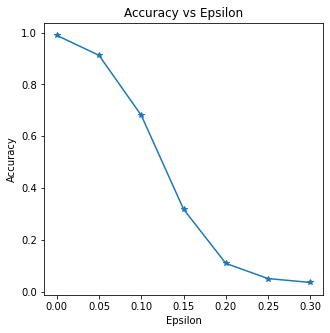

In [34]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

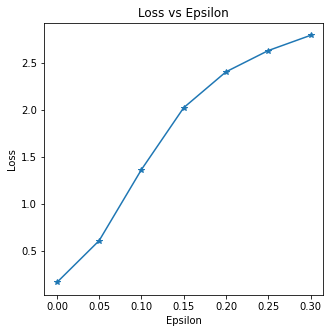

In [35]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, loss, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Loss vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.show()

https://arxiv.org/abs/2205.10457

https://arxiv.org/abs/1804.00097